# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

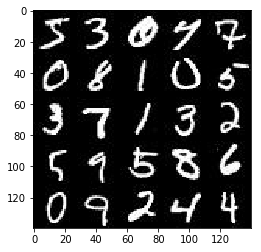

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

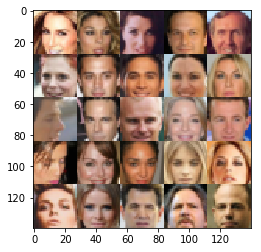

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, shape = (None, *real_dim), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, shape = (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        alpha = 0.2
        # Input layer is 28x28x3 or 1
        x1 = tf.layers.conv2d(images, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        # print(relu1.shape)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # print(relu2.shape)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # print(relu3.shape)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse = reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # print(x1.shape)
        # 3x3x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size = 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # print(x2.shape)
        # 6x6x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size = 4, strides = 2, padding = 'valid')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # print(x3.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size = 5, strides = 2, padding = 'same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 1 if data_image_mode == 'L' else 3
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # batch images from [-0.5, 0.5] to [-1, 1]
                image_input = 2 * batch_images
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images,
                                                     learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: batch_z})
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1454... Generator Loss: 0.1424
Epoch 1/2... Discriminator Loss: 0.0055... Generator Loss: 6.4604
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 9.8237
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 3.1600
Epoch 1/2... Discriminator Loss: 1.7300... Generator Loss: 0.3569
Epoch 1/2... Discriminator Loss: 0.7846... Generator Loss: 3.5602
Epoch 1/2... Discriminator Loss: 0.0715... Generator Loss: 3.3332
Epoch 1/2... Discriminator Loss: 0.3412... Generator Loss: 2.4933
Epoch 1/2... Discriminator Loss: 0.1116... Generator Loss: 3.4691
Epoch 1/2... Discriminator Loss: 0.1912... Generator Loss: 6.1301


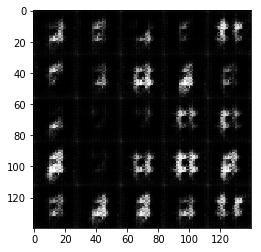

Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 4.8483
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 6.5150
Epoch 1/2... Discriminator Loss: 0.3209... Generator Loss: 2.2005
Epoch 1/2... Discriminator Loss: 0.2544... Generator Loss: 2.2657
Epoch 1/2... Discriminator Loss: 0.0501... Generator Loss: 4.0740
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 6.7361
Epoch 1/2... Discriminator Loss: 0.0968... Generator Loss: 3.4979
Epoch 1/2... Discriminator Loss: 0.0664... Generator Loss: 3.7058
Epoch 1/2... Discriminator Loss: 0.0485... Generator Loss: 4.0410
Epoch 1/2... Discriminator Loss: 0.1042... Generator Loss: 2.9527


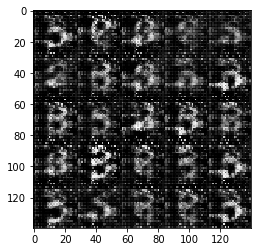

Epoch 1/2... Discriminator Loss: 0.0894... Generator Loss: 3.0638
Epoch 1/2... Discriminator Loss: 1.6159... Generator Loss: 0.9762
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 0.8396
Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 1.6803
Epoch 1/2... Discriminator Loss: 0.2781... Generator Loss: 2.0035
Epoch 1/2... Discriminator Loss: 0.4362... Generator Loss: 1.7890
Epoch 1/2... Discriminator Loss: 0.2560... Generator Loss: 2.4252
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 1.5113
Epoch 1/2... Discriminator Loss: 0.3727... Generator Loss: 1.5980
Epoch 1/2... Discriminator Loss: 0.4603... Generator Loss: 3.7753


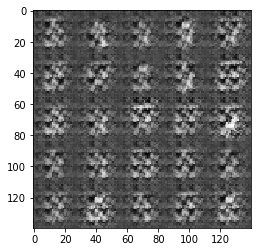

Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 1.9751
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 1.7322
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 0.2377... Generator Loss: 2.6934
Epoch 1/2... Discriminator Loss: 0.1172... Generator Loss: 3.4869
Epoch 1/2... Discriminator Loss: 0.1692... Generator Loss: 3.1624
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.6638
Epoch 1/2... Discriminator Loss: 0.1771... Generator Loss: 5.5514
Epoch 1/2... Discriminator Loss: 0.2290... Generator Loss: 4.4810
Epoch 1/2... Discriminator Loss: 0.1081... Generator Loss: 3.5231


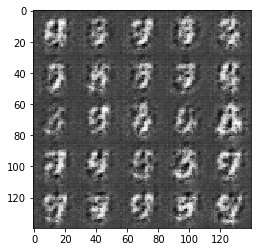

Epoch 1/2... Discriminator Loss: 0.0884... Generator Loss: 6.6042
Epoch 1/2... Discriminator Loss: 6.3661... Generator Loss: 0.0042
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 2.6953
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 1.6206
Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 1.5904
Epoch 2/2... Discriminator Loss: 0.4757... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.7240
Epoch 2/2... Discriminator Loss: 0.3697... Generator Loss: 1.6805


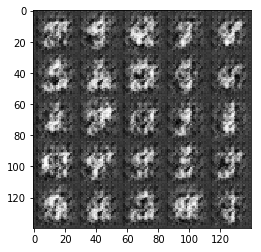

Epoch 2/2... Discriminator Loss: 0.2570... Generator Loss: 1.8935
Epoch 2/2... Discriminator Loss: 0.1073... Generator Loss: 2.9132
Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 4.9318
Epoch 2/2... Discriminator Loss: 0.0422... Generator Loss: 4.4678
Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 0.3691
Epoch 2/2... Discriminator Loss: 0.2974... Generator Loss: 2.1156
Epoch 2/2... Discriminator Loss: 0.2546... Generator Loss: 2.1542
Epoch 2/2... Discriminator Loss: 0.1797... Generator Loss: 2.7376
Epoch 2/2... Discriminator Loss: 0.0768... Generator Loss: 4.0101
Epoch 2/2... Discriminator Loss: 0.1179... Generator Loss: 2.6008


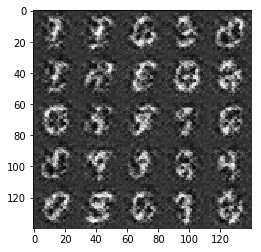

Epoch 2/2... Discriminator Loss: 0.0407... Generator Loss: 4.2205
Epoch 2/2... Discriminator Loss: 0.4265... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.9143
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 0.6455... Generator Loss: 1.2345
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 3.5653
Epoch 2/2... Discriminator Loss: 0.2315... Generator Loss: 2.1397
Epoch 2/2... Discriminator Loss: 0.0560... Generator Loss: 4.1659
Epoch 2/2... Discriminator Loss: 0.2908... Generator Loss: 4.6833
Epoch 2/2... Discriminator Loss: 0.1706... Generator Loss: 2.4555


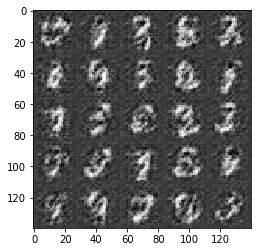

Epoch 2/2... Discriminator Loss: 0.1235... Generator Loss: 2.7994
Epoch 2/2... Discriminator Loss: 0.0498... Generator Loss: 3.8982
Epoch 2/2... Discriminator Loss: 0.2379... Generator Loss: 2.2029
Epoch 2/2... Discriminator Loss: 0.2569... Generator Loss: 2.5039
Epoch 2/2... Discriminator Loss: 0.0265... Generator Loss: 5.0601
Epoch 2/2... Discriminator Loss: 0.1077... Generator Loss: 2.6121
Epoch 2/2... Discriminator Loss: 0.0863... Generator Loss: 3.1206
Epoch 2/2... Discriminator Loss: 0.4505... Generator Loss: 1.2401
Epoch 2/2... Discriminator Loss: 0.0215... Generator Loss: 6.1960
Epoch 2/2... Discriminator Loss: 0.0176... Generator Loss: 5.8709


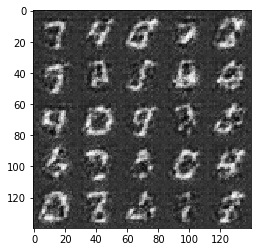

Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 6.2039
Epoch 2/2... Discriminator Loss: 0.0439... Generator Loss: 3.9601
Epoch 2/2... Discriminator Loss: 0.0230... Generator Loss: 4.6617
Epoch 2/2... Discriminator Loss: 0.0325... Generator Loss: 4.4989
Epoch 2/2... Discriminator Loss: 0.1577... Generator Loss: 2.2002
Epoch 2/2... Discriminator Loss: 0.0477... Generator Loss: 3.5082
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 1.8284
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.1999
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.1311
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 0.8687


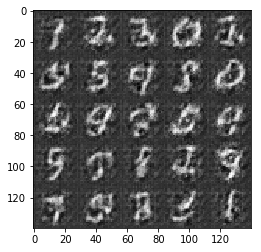

Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 1.5911
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 3.5715


In [21]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 1.2461... Generator Loss: 0.7018
Epoch 1/10... Discriminator Loss: 0.7118... Generator Loss: 1.3527
Epoch 1/10... Discriminator Loss: 0.3878... Generator Loss: 1.7918
Epoch 1/10... Discriminator Loss: 0.3749... Generator Loss: 1.9081
Epoch 1/10... Discriminator Loss: 0.2135... Generator Loss: 2.3964
Epoch 1/10... Discriminator Loss: 0.2391... Generator Loss: 2.4063
Epoch 1/10... Discriminator Loss: 0.3123... Generator Loss: 2.0243
Epoch 1/10... Discriminator Loss: 0.2952... Generator Loss: 3.5771
Epoch 1/10... Discriminator Loss: 0.3013... Generator Loss: 1.9627
Epoch 1/10... Discriminator Loss: 0.3752... Generator Loss: 1.7571


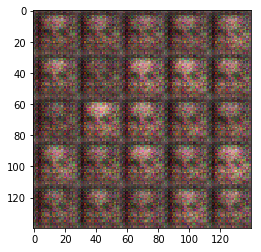

Epoch 1/10... Discriminator Loss: 0.4384... Generator Loss: 3.4179
Epoch 1/10... Discriminator Loss: 0.3234... Generator Loss: 2.3450
Epoch 1/10... Discriminator Loss: 0.4303... Generator Loss: 1.3836
Epoch 1/10... Discriminator Loss: 0.2601... Generator Loss: 2.4541
Epoch 1/10... Discriminator Loss: 0.2941... Generator Loss: 2.2232
Epoch 1/10... Discriminator Loss: 0.1673... Generator Loss: 2.6793
Epoch 1/10... Discriminator Loss: 0.1889... Generator Loss: 2.5342
Epoch 1/10... Discriminator Loss: 0.2225... Generator Loss: 2.3938
Epoch 1/10... Discriminator Loss: 0.1208... Generator Loss: 3.0448
Epoch 1/10... Discriminator Loss: 0.2071... Generator Loss: 2.4994


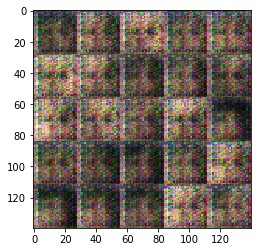

Epoch 1/10... Discriminator Loss: 0.1756... Generator Loss: 2.4810
Epoch 1/10... Discriminator Loss: 0.1955... Generator Loss: 2.2069
Epoch 1/10... Discriminator Loss: 0.2715... Generator Loss: 4.4747
Epoch 1/10... Discriminator Loss: 2.9282... Generator Loss: 8.1855
Epoch 1/10... Discriminator Loss: 2.0243... Generator Loss: 0.1885
Epoch 1/10... Discriminator Loss: 0.3948... Generator Loss: 3.3186
Epoch 1/10... Discriminator Loss: 0.6519... Generator Loss: 6.5620
Epoch 1/10... Discriminator Loss: 2.2596... Generator Loss: 0.1472
Epoch 1/10... Discriminator Loss: 3.4934... Generator Loss: 0.0447
Epoch 1/10... Discriminator Loss: 1.3369... Generator Loss: 0.4388


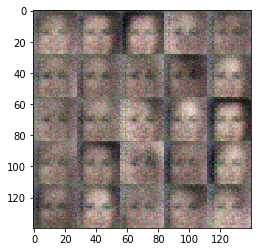

Epoch 1/10... Discriminator Loss: 0.8697... Generator Loss: 2.3297
Epoch 1/10... Discriminator Loss: 0.2908... Generator Loss: 2.8489
Epoch 1/10... Discriminator Loss: 1.2467... Generator Loss: 3.6924
Epoch 1/10... Discriminator Loss: 0.6702... Generator Loss: 1.2634
Epoch 1/10... Discriminator Loss: 0.3168... Generator Loss: 3.0794
Epoch 1/10... Discriminator Loss: 0.2780... Generator Loss: 2.0757
Epoch 1/10... Discriminator Loss: 0.4485... Generator Loss: 1.8301
Epoch 1/10... Discriminator Loss: 0.0785... Generator Loss: 4.1703
Epoch 1/10... Discriminator Loss: 0.1034... Generator Loss: 4.5462
Epoch 1/10... Discriminator Loss: 0.5001... Generator Loss: 3.1239


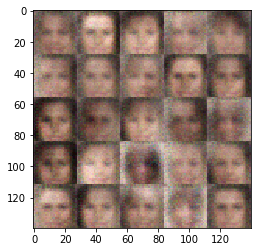

Epoch 1/10... Discriminator Loss: 0.4140... Generator Loss: 3.1983
Epoch 1/10... Discriminator Loss: 0.4668... Generator Loss: 1.4340
Epoch 1/10... Discriminator Loss: 0.8063... Generator Loss: 0.7638
Epoch 1/10... Discriminator Loss: 0.4691... Generator Loss: 3.8821
Epoch 1/10... Discriminator Loss: 0.2397... Generator Loss: 2.4550
Epoch 1/10... Discriminator Loss: 0.4448... Generator Loss: 7.5933
Epoch 1/10... Discriminator Loss: 0.2417... Generator Loss: 2.3910
Epoch 1/10... Discriminator Loss: 1.1668... Generator Loss: 0.4521
Epoch 1/10... Discriminator Loss: 0.6325... Generator Loss: 2.3219
Epoch 1/10... Discriminator Loss: 1.0535... Generator Loss: 3.4535


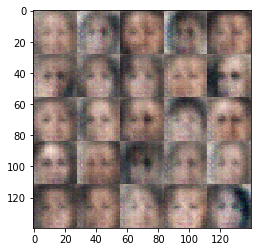

Epoch 1/10... Discriminator Loss: 0.5828... Generator Loss: 7.0734
Epoch 1/10... Discriminator Loss: 0.1914... Generator Loss: 4.0975
Epoch 1/10... Discriminator Loss: 0.5872... Generator Loss: 1.0383
Epoch 1/10... Discriminator Loss: 1.5301... Generator Loss: 0.3207
Epoch 1/10... Discriminator Loss: 2.0271... Generator Loss: 0.1823
Epoch 1/10... Discriminator Loss: 0.2765... Generator Loss: 7.4069
Epoch 1/10... Discriminator Loss: 0.5522... Generator Loss: 2.4285
Epoch 1/10... Discriminator Loss: 0.7787... Generator Loss: 3.6592
Epoch 1/10... Discriminator Loss: 0.8812... Generator Loss: 1.6097
Epoch 1/10... Discriminator Loss: 0.2540... Generator Loss: 4.6447


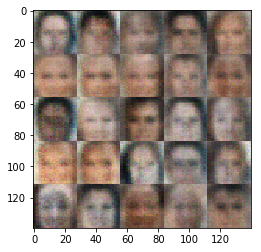

Epoch 1/10... Discriminator Loss: 0.2882... Generator Loss: 1.7066
Epoch 1/10... Discriminator Loss: 0.1172... Generator Loss: 5.9454
Epoch 1/10... Discriminator Loss: 0.2834... Generator Loss: 1.7120
Epoch 1/10... Discriminator Loss: 0.8548... Generator Loss: 0.6963
Epoch 1/10... Discriminator Loss: 0.1548... Generator Loss: 3.7955
Epoch 1/10... Discriminator Loss: 0.1298... Generator Loss: 5.1763
Epoch 1/10... Discriminator Loss: 2.0084... Generator Loss: 0.1949
Epoch 1/10... Discriminator Loss: 0.2130... Generator Loss: 3.2188
Epoch 1/10... Discriminator Loss: 0.1221... Generator Loss: 3.3281
Epoch 1/10... Discriminator Loss: 0.1886... Generator Loss: 3.1515


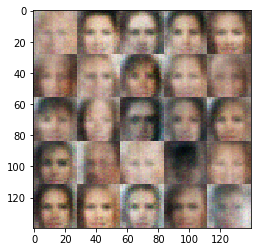

Epoch 1/10... Discriminator Loss: 0.0550... Generator Loss: 5.1580
Epoch 1/10... Discriminator Loss: 0.9246... Generator Loss: 0.6017
Epoch 1/10... Discriminator Loss: 0.6048... Generator Loss: 0.9515
Epoch 1/10... Discriminator Loss: 0.1892... Generator Loss: 8.7664
Epoch 1/10... Discriminator Loss: 0.5486... Generator Loss: 1.1561
Epoch 1/10... Discriminator Loss: 0.0169... Generator Loss: 5.5026
Epoch 1/10... Discriminator Loss: 0.0371... Generator Loss: 4.1397
Epoch 1/10... Discriminator Loss: 0.0919... Generator Loss: 3.1656
Epoch 1/10... Discriminator Loss: 1.3277... Generator Loss: 0.3683
Epoch 2/10... Discriminator Loss: 0.7368... Generator Loss: 8.9925


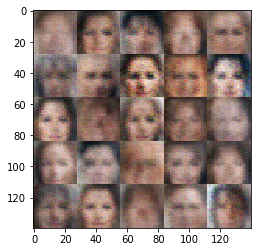

Epoch 2/10... Discriminator Loss: 0.0908... Generator Loss: 3.0952
Epoch 2/10... Discriminator Loss: 0.2416... Generator Loss: 9.3572
Epoch 2/10... Discriminator Loss: 1.3196... Generator Loss: 7.3112
Epoch 2/10... Discriminator Loss: 0.0450... Generator Loss: 4.9423
Epoch 2/10... Discriminator Loss: 0.1039... Generator Loss: 10.7286
Epoch 2/10... Discriminator Loss: 0.1003... Generator Loss: 5.3678
Epoch 2/10... Discriminator Loss: 0.0465... Generator Loss: 4.7922
Epoch 2/10... Discriminator Loss: 0.1539... Generator Loss: 11.5578
Epoch 2/10... Discriminator Loss: 0.0515... Generator Loss: 4.5325
Epoch 2/10... Discriminator Loss: 0.1234... Generator Loss: 2.9842


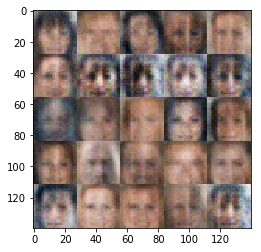

Epoch 2/10... Discriminator Loss: 0.0327... Generator Loss: 8.3606
Epoch 2/10... Discriminator Loss: 0.0710... Generator Loss: 4.2748
Epoch 2/10... Discriminator Loss: 0.5754... Generator Loss: 0.9848
Epoch 2/10... Discriminator Loss: 0.4052... Generator Loss: 1.3525
Epoch 2/10... Discriminator Loss: 0.0419... Generator Loss: 7.9838
Epoch 2/10... Discriminator Loss: 0.0244... Generator Loss: 7.1060
Epoch 2/10... Discriminator Loss: 0.2436... Generator Loss: 10.1435
Epoch 2/10... Discriminator Loss: 0.2665... Generator Loss: 1.9106
Epoch 2/10... Discriminator Loss: 0.0312... Generator Loss: 10.3233
Epoch 2/10... Discriminator Loss: 0.0363... Generator Loss: 6.4729


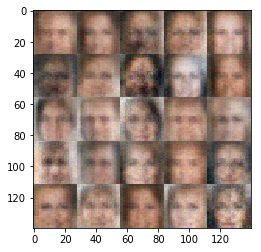

Epoch 2/10... Discriminator Loss: 0.0325... Generator Loss: 8.7188
Epoch 2/10... Discriminator Loss: 0.0404... Generator Loss: 10.0437
Epoch 2/10... Discriminator Loss: 0.8440... Generator Loss: 1.0203
Epoch 2/10... Discriminator Loss: 0.3177... Generator Loss: 1.4984
Epoch 2/10... Discriminator Loss: 0.0488... Generator Loss: 6.4332
Epoch 2/10... Discriminator Loss: 1.4046... Generator Loss: 0.3217
Epoch 2/10... Discriminator Loss: 0.0592... Generator Loss: 5.1999
Epoch 2/10... Discriminator Loss: 0.1307... Generator Loss: 2.7847
Epoch 2/10... Discriminator Loss: 0.0150... Generator Loss: 9.0807
Epoch 2/10... Discriminator Loss: 0.6124... Generator Loss: 1.0422


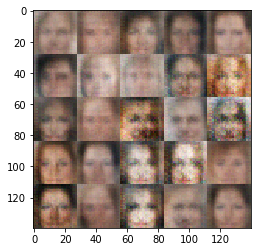

Epoch 2/10... Discriminator Loss: 0.8943... Generator Loss: 0.6503
Epoch 2/10... Discriminator Loss: 0.5755... Generator Loss: 1.0598
Epoch 2/10... Discriminator Loss: 0.0689... Generator Loss: 6.6377
Epoch 2/10... Discriminator Loss: 0.1225... Generator Loss: 9.0101
Epoch 2/10... Discriminator Loss: 0.0569... Generator Loss: 11.7637
Epoch 2/10... Discriminator Loss: 0.1542... Generator Loss: 3.1275
Epoch 2/10... Discriminator Loss: 0.0667... Generator Loss: 7.3139
Epoch 2/10... Discriminator Loss: 0.0974... Generator Loss: 3.0100
Epoch 2/10... Discriminator Loss: 0.2722... Generator Loss: 1.8323
Epoch 2/10... Discriminator Loss: 0.0858... Generator Loss: 5.0764


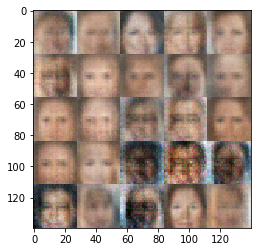

Epoch 2/10... Discriminator Loss: 0.0367... Generator Loss: 9.6087
Epoch 2/10... Discriminator Loss: 0.1682... Generator Loss: 2.7904
Epoch 2/10... Discriminator Loss: 0.0234... Generator Loss: 11.1044
Epoch 2/10... Discriminator Loss: 0.0420... Generator Loss: 8.2565
Epoch 2/10... Discriminator Loss: 0.6182... Generator Loss: 0.9456
Epoch 2/10... Discriminator Loss: 0.0448... Generator Loss: 11.6937
Epoch 2/10... Discriminator Loss: 0.1310... Generator Loss: 9.7760
Epoch 2/10... Discriminator Loss: 0.0750... Generator Loss: 4.0848
Epoch 2/10... Discriminator Loss: 0.2031... Generator Loss: 13.3132
Epoch 2/10... Discriminator Loss: 0.0968... Generator Loss: 9.7918


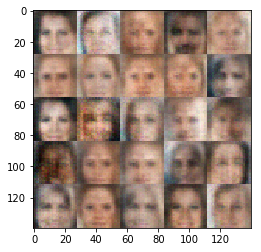

Epoch 2/10... Discriminator Loss: 0.0487... Generator Loss: 5.9745
Epoch 2/10... Discriminator Loss: 0.4619... Generator Loss: 1.2971
Epoch 2/10... Discriminator Loss: 0.1016... Generator Loss: 9.4335
Epoch 2/10... Discriminator Loss: 0.0731... Generator Loss: 3.4941
Epoch 2/10... Discriminator Loss: 0.2106... Generator Loss: 2.4188
Epoch 2/10... Discriminator Loss: 2.5676... Generator Loss: 5.9411
Epoch 2/10... Discriminator Loss: 1.3877... Generator Loss: 0.5453
Epoch 2/10... Discriminator Loss: 0.1684... Generator Loss: 2.2640
Epoch 2/10... Discriminator Loss: 0.0307... Generator Loss: 7.6851
Epoch 2/10... Discriminator Loss: 0.1022... Generator Loss: 9.3294


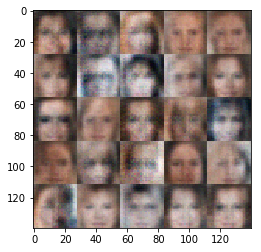

Epoch 2/10... Discriminator Loss: 0.1860... Generator Loss: 6.7175
Epoch 2/10... Discriminator Loss: 0.0232... Generator Loss: 9.1718
Epoch 2/10... Discriminator Loss: 0.0744... Generator Loss: 9.0406
Epoch 2/10... Discriminator Loss: 0.0727... Generator Loss: 3.6202
Epoch 2/10... Discriminator Loss: 0.0531... Generator Loss: 5.9932
Epoch 2/10... Discriminator Loss: 0.8254... Generator Loss: 0.6872
Epoch 2/10... Discriminator Loss: 0.0881... Generator Loss: 3.5825
Epoch 2/10... Discriminator Loss: 0.0930... Generator Loss: 3.2010
Epoch 2/10... Discriminator Loss: 0.0900... Generator Loss: 5.8084
Epoch 2/10... Discriminator Loss: 0.2488... Generator Loss: 4.5700


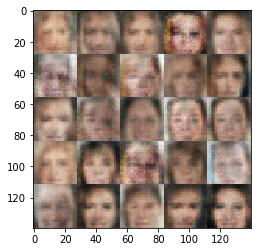

Epoch 2/10... Discriminator Loss: 0.0673... Generator Loss: 10.7273
Epoch 2/10... Discriminator Loss: 0.0502... Generator Loss: 10.3700
Epoch 2/10... Discriminator Loss: 0.0278... Generator Loss: 10.2171
Epoch 2/10... Discriminator Loss: 0.0309... Generator Loss: 8.2174
Epoch 2/10... Discriminator Loss: 0.0795... Generator Loss: 8.5413
Epoch 2/10... Discriminator Loss: 0.0106... Generator Loss: 7.1685
Epoch 2/10... Discriminator Loss: 0.0346... Generator Loss: 11.1034
Epoch 2/10... Discriminator Loss: 0.0226... Generator Loss: 8.2911
Epoch 3/10... Discriminator Loss: 0.0299... Generator Loss: 4.5735
Epoch 3/10... Discriminator Loss: 0.1668... Generator Loss: 4.1588


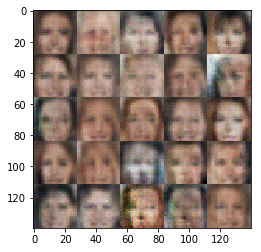

Epoch 3/10... Discriminator Loss: 0.0909... Generator Loss: 2.8534
Epoch 3/10... Discriminator Loss: 0.0998... Generator Loss: 8.0500
Epoch 3/10... Discriminator Loss: 0.7184... Generator Loss: 0.9716
Epoch 3/10... Discriminator Loss: 0.0512... Generator Loss: 7.3206
Epoch 3/10... Discriminator Loss: 0.0701... Generator Loss: 5.5683
Epoch 3/10... Discriminator Loss: 0.0588... Generator Loss: 6.0952
Epoch 3/10... Discriminator Loss: 0.0246... Generator Loss: 9.9912
Epoch 3/10... Discriminator Loss: 0.0412... Generator Loss: 8.9098
Epoch 3/10... Discriminator Loss: 0.0190... Generator Loss: 8.6796
Epoch 3/10... Discriminator Loss: 0.4371... Generator Loss: 1.6518


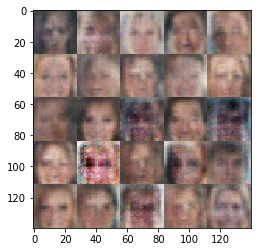

Epoch 3/10... Discriminator Loss: 1.8877... Generator Loss: 0.2357
Epoch 3/10... Discriminator Loss: 0.4617... Generator Loss: 7.7677
Epoch 3/10... Discriminator Loss: 0.1023... Generator Loss: 3.1409
Epoch 3/10... Discriminator Loss: 0.5862... Generator Loss: 1.0174
Epoch 3/10... Discriminator Loss: 0.6615... Generator Loss: 0.9479
Epoch 3/10... Discriminator Loss: 0.1333... Generator Loss: 5.0690
Epoch 3/10... Discriminator Loss: 0.1275... Generator Loss: 5.5615
Epoch 3/10... Discriminator Loss: 0.1434... Generator Loss: 2.7803
Epoch 3/10... Discriminator Loss: 0.7493... Generator Loss: 0.7587
Epoch 3/10... Discriminator Loss: 0.2055... Generator Loss: 3.0431


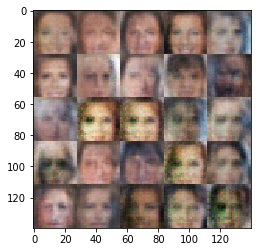

Epoch 3/10... Discriminator Loss: 0.0677... Generator Loss: 4.2747
Epoch 3/10... Discriminator Loss: 0.2901... Generator Loss: 1.8018
Epoch 3/10... Discriminator Loss: 0.0235... Generator Loss: 8.0422
Epoch 3/10... Discriminator Loss: 0.1436... Generator Loss: 3.5873
Epoch 3/10... Discriminator Loss: 0.1119... Generator Loss: 5.2911
Epoch 3/10... Discriminator Loss: 0.1180... Generator Loss: 3.0504
Epoch 3/10... Discriminator Loss: 0.1209... Generator Loss: 5.2403
Epoch 3/10... Discriminator Loss: 0.4558... Generator Loss: 1.1660
Epoch 3/10... Discriminator Loss: 0.0470... Generator Loss: 4.5661
Epoch 3/10... Discriminator Loss: 0.0324... Generator Loss: 9.9917


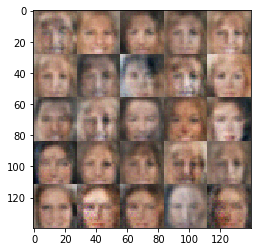

Epoch 3/10... Discriminator Loss: 0.0167... Generator Loss: 10.9886
Epoch 3/10... Discriminator Loss: 0.1168... Generator Loss: 7.5979
Epoch 3/10... Discriminator Loss: 0.3956... Generator Loss: 1.3339
Epoch 3/10... Discriminator Loss: 0.0182... Generator Loss: 6.7116
Epoch 3/10... Discriminator Loss: 0.0201... Generator Loss: 8.0528
Epoch 3/10... Discriminator Loss: 0.0745... Generator Loss: 4.0028
Epoch 3/10... Discriminator Loss: 0.0653... Generator Loss: 3.1754
Epoch 3/10... Discriminator Loss: 2.2201... Generator Loss: 0.1902
Epoch 3/10... Discriminator Loss: 0.8498... Generator Loss: 0.7723
Epoch 3/10... Discriminator Loss: 0.1342... Generator Loss: 3.6995


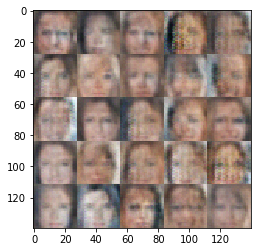

Epoch 3/10... Discriminator Loss: 0.1209... Generator Loss: 3.6224
Epoch 3/10... Discriminator Loss: 0.1162... Generator Loss: 3.2568
Epoch 3/10... Discriminator Loss: 0.3981... Generator Loss: 1.5604
Epoch 3/10... Discriminator Loss: 0.1926... Generator Loss: 4.1891
Epoch 3/10... Discriminator Loss: 0.0632... Generator Loss: 5.3086
Epoch 3/10... Discriminator Loss: 0.5162... Generator Loss: 1.2337
Epoch 3/10... Discriminator Loss: 0.1331... Generator Loss: 6.4807
Epoch 3/10... Discriminator Loss: 0.0976... Generator Loss: 9.8048
Epoch 3/10... Discriminator Loss: 0.1544... Generator Loss: 7.0760
Epoch 3/10... Discriminator Loss: 0.2318... Generator Loss: 10.8834


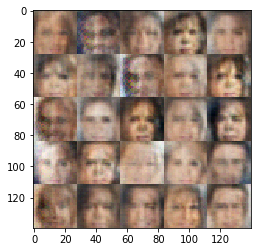

Epoch 3/10... Discriminator Loss: 0.1134... Generator Loss: 2.8048
Epoch 3/10... Discriminator Loss: 0.0726... Generator Loss: 4.6343
Epoch 3/10... Discriminator Loss: 0.1443... Generator Loss: 8.6146
Epoch 3/10... Discriminator Loss: 0.0537... Generator Loss: 11.7835
Epoch 3/10... Discriminator Loss: 0.1946... Generator Loss: 6.5543
Epoch 3/10... Discriminator Loss: 0.2753... Generator Loss: 2.0049
Epoch 3/10... Discriminator Loss: 0.0188... Generator Loss: 9.2116
Epoch 3/10... Discriminator Loss: 0.0675... Generator Loss: 6.0557
Epoch 3/10... Discriminator Loss: 0.0539... Generator Loss: 6.1372
Epoch 3/10... Discriminator Loss: 0.0454... Generator Loss: 6.6515


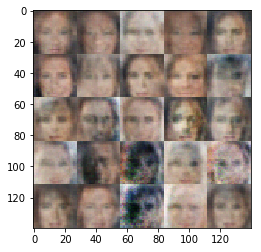

Epoch 3/10... Discriminator Loss: 0.0364... Generator Loss: 4.3706
Epoch 3/10... Discriminator Loss: 0.0719... Generator Loss: 3.4033
Epoch 3/10... Discriminator Loss: 0.0833... Generator Loss: 4.4002
Epoch 3/10... Discriminator Loss: 0.0724... Generator Loss: 5.9260
Epoch 3/10... Discriminator Loss: 0.3061... Generator Loss: 1.6630
Epoch 3/10... Discriminator Loss: 0.0748... Generator Loss: 8.8218
Epoch 3/10... Discriminator Loss: 0.4330... Generator Loss: 1.2794
Epoch 3/10... Discriminator Loss: 0.0319... Generator Loss: 5.4202
Epoch 3/10... Discriminator Loss: 0.9420... Generator Loss: 0.5832
Epoch 3/10... Discriminator Loss: 0.2193... Generator Loss: 2.3441


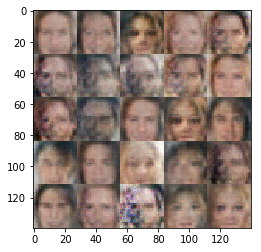

Epoch 3/10... Discriminator Loss: 0.0269... Generator Loss: 8.3447
Epoch 3/10... Discriminator Loss: 0.0779... Generator Loss: 5.2027
Epoch 3/10... Discriminator Loss: 0.0992... Generator Loss: 3.2864
Epoch 3/10... Discriminator Loss: 0.1094... Generator Loss: 3.0693
Epoch 3/10... Discriminator Loss: 0.6600... Generator Loss: 0.8859
Epoch 3/10... Discriminator Loss: 1.9957... Generator Loss: 8.1729
Epoch 3/10... Discriminator Loss: 0.2607... Generator Loss: 6.0208
Epoch 4/10... Discriminator Loss: 0.1802... Generator Loss: 2.6713
Epoch 4/10... Discriminator Loss: 0.0394... Generator Loss: 6.1090
Epoch 4/10... Discriminator Loss: 0.0460... Generator Loss: 5.7349


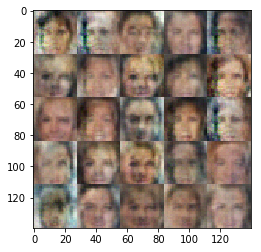

Epoch 4/10... Discriminator Loss: 0.0757... Generator Loss: 5.3170
Epoch 4/10... Discriminator Loss: 0.0353... Generator Loss: 7.4701
Epoch 4/10... Discriminator Loss: 0.3734... Generator Loss: 1.5621
Epoch 4/10... Discriminator Loss: 0.3442... Generator Loss: 9.0289
Epoch 4/10... Discriminator Loss: 0.1955... Generator Loss: 4.2474
Epoch 4/10... Discriminator Loss: 0.1867... Generator Loss: 2.4045
Epoch 4/10... Discriminator Loss: 0.5413... Generator Loss: 6.0047
Epoch 4/10... Discriminator Loss: 0.5149... Generator Loss: 1.1749
Epoch 4/10... Discriminator Loss: 0.0570... Generator Loss: 3.9247
Epoch 4/10... Discriminator Loss: 0.1394... Generator Loss: 6.8289


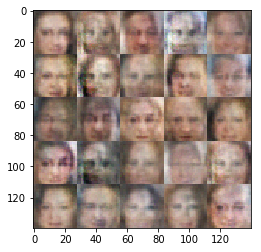

Epoch 4/10... Discriminator Loss: 0.7256... Generator Loss: 0.8438
Epoch 4/10... Discriminator Loss: 0.0736... Generator Loss: 3.8168
Epoch 4/10... Discriminator Loss: 0.0412... Generator Loss: 6.8815
Epoch 4/10... Discriminator Loss: 0.6467... Generator Loss: 12.2072
Epoch 4/10... Discriminator Loss: 0.0654... Generator Loss: 10.1286
Epoch 4/10... Discriminator Loss: 0.1799... Generator Loss: 2.2426
Epoch 4/10... Discriminator Loss: 0.2095... Generator Loss: 1.9916
Epoch 4/10... Discriminator Loss: 0.0650... Generator Loss: 11.3324
Epoch 4/10... Discriminator Loss: 0.0470... Generator Loss: 7.9760
Epoch 4/10... Discriminator Loss: 0.3551... Generator Loss: 1.6270


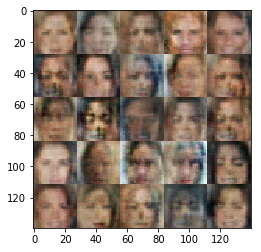

Epoch 4/10... Discriminator Loss: 0.0509... Generator Loss: 12.5320
Epoch 4/10... Discriminator Loss: 0.0749... Generator Loss: 3.6434
Epoch 4/10... Discriminator Loss: 0.4025... Generator Loss: 12.7941
Epoch 4/10... Discriminator Loss: 0.1230... Generator Loss: 4.0459
Epoch 4/10... Discriminator Loss: 0.0557... Generator Loss: 4.4543
Epoch 4/10... Discriminator Loss: 0.0654... Generator Loss: 11.5975
Epoch 4/10... Discriminator Loss: 0.0587... Generator Loss: 4.5542
Epoch 4/10... Discriminator Loss: 0.3114... Generator Loss: 1.6410
Epoch 4/10... Discriminator Loss: 0.5843... Generator Loss: 8.8400
Epoch 4/10... Discriminator Loss: 0.0896... Generator Loss: 3.1770


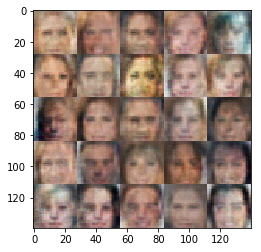

Epoch 4/10... Discriminator Loss: 0.5078... Generator Loss: 7.4553
Epoch 4/10... Discriminator Loss: 0.0674... Generator Loss: 9.1665
Epoch 4/10... Discriminator Loss: 0.0085... Generator Loss: 8.2470
Epoch 4/10... Discriminator Loss: 0.0812... Generator Loss: 7.7399
Epoch 4/10... Discriminator Loss: 0.0129... Generator Loss: 8.1183
Epoch 4/10... Discriminator Loss: 0.2654... Generator Loss: 1.8342
Epoch 4/10... Discriminator Loss: 0.0646... Generator Loss: 9.5195
Epoch 4/10... Discriminator Loss: 0.0450... Generator Loss: 5.7706
Epoch 4/10... Discriminator Loss: 0.9743... Generator Loss: 0.7132
Epoch 4/10... Discriminator Loss: 0.0441... Generator Loss: 7.7585


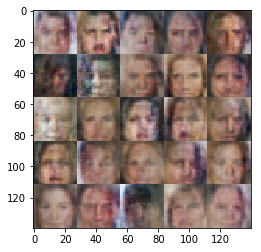

Epoch 4/10... Discriminator Loss: 0.0871... Generator Loss: 3.4264
Epoch 4/10... Discriminator Loss: 1.5375... Generator Loss: 8.3126
Epoch 4/10... Discriminator Loss: 1.7604... Generator Loss: 13.9312
Epoch 4/10... Discriminator Loss: 0.2220... Generator Loss: 2.6911
Epoch 4/10... Discriminator Loss: 0.2186... Generator Loss: 2.2725
Epoch 4/10... Discriminator Loss: 0.0618... Generator Loss: 4.9638
Epoch 4/10... Discriminator Loss: 0.2833... Generator Loss: 7.9445
Epoch 4/10... Discriminator Loss: 0.1004... Generator Loss: 3.4194
Epoch 4/10... Discriminator Loss: 0.0776... Generator Loss: 6.2151
Epoch 4/10... Discriminator Loss: 0.1445... Generator Loss: 3.4485


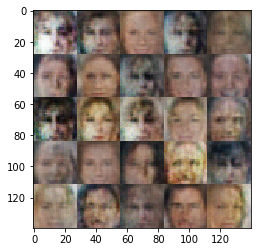

Epoch 4/10... Discriminator Loss: 0.1530... Generator Loss: 2.6661
Epoch 4/10... Discriminator Loss: 0.9472... Generator Loss: 0.6153
Epoch 4/10... Discriminator Loss: 0.1569... Generator Loss: 2.4312
Epoch 4/10... Discriminator Loss: 0.0522... Generator Loss: 4.5476
Epoch 4/10... Discriminator Loss: 0.0331... Generator Loss: 4.7753
Epoch 4/10... Discriminator Loss: 0.3880... Generator Loss: 1.6406
Epoch 4/10... Discriminator Loss: 0.0616... Generator Loss: 3.8800
Epoch 4/10... Discriminator Loss: 0.0401... Generator Loss: 10.4678
Epoch 4/10... Discriminator Loss: 0.8027... Generator Loss: 0.7133
Epoch 4/10... Discriminator Loss: 0.1681... Generator Loss: 6.9406


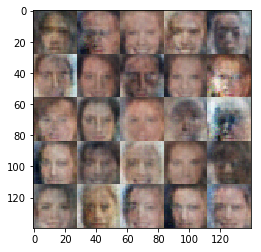

Epoch 4/10... Discriminator Loss: 0.0497... Generator Loss: 10.9571
Epoch 4/10... Discriminator Loss: 0.0597... Generator Loss: 5.4565
Epoch 4/10... Discriminator Loss: 0.1465... Generator Loss: 6.9270
Epoch 4/10... Discriminator Loss: 0.0545... Generator Loss: 4.5612
Epoch 4/10... Discriminator Loss: 0.1199... Generator Loss: 2.7661
Epoch 4/10... Discriminator Loss: 0.6495... Generator Loss: 0.9540
Epoch 4/10... Discriminator Loss: 0.0421... Generator Loss: 6.7472
Epoch 4/10... Discriminator Loss: 0.8601... Generator Loss: 0.7168
Epoch 4/10... Discriminator Loss: 0.0235... Generator Loss: 8.5827
Epoch 4/10... Discriminator Loss: 0.0287... Generator Loss: 5.1983


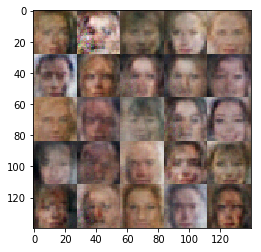

Epoch 4/10... Discriminator Loss: 0.0402... Generator Loss: 7.4892
Epoch 4/10... Discriminator Loss: 0.5245... Generator Loss: 1.1756
Epoch 4/10... Discriminator Loss: 0.0717... Generator Loss: 3.2823
Epoch 4/10... Discriminator Loss: 0.0797... Generator Loss: 4.2503
Epoch 4/10... Discriminator Loss: 0.3896... Generator Loss: 3.6004
Epoch 4/10... Discriminator Loss: 0.0263... Generator Loss: 4.8032
Epoch 5/10... Discriminator Loss: 0.0990... Generator Loss: 6.3016
Epoch 5/10... Discriminator Loss: 0.1043... Generator Loss: 6.9053
Epoch 5/10... Discriminator Loss: 0.1184... Generator Loss: 4.3764
Epoch 5/10... Discriminator Loss: 0.0350... Generator Loss: 5.2368


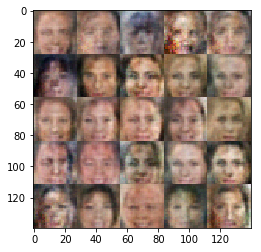

Epoch 5/10... Discriminator Loss: 0.0527... Generator Loss: 7.6950
Epoch 5/10... Discriminator Loss: 0.0648... Generator Loss: 4.7424
Epoch 5/10... Discriminator Loss: 0.0743... Generator Loss: 7.4637
Epoch 5/10... Discriminator Loss: 0.0213... Generator Loss: 6.4332
Epoch 5/10... Discriminator Loss: 0.0233... Generator Loss: 7.6661
Epoch 5/10... Discriminator Loss: 1.2399... Generator Loss: 0.4259
Epoch 5/10... Discriminator Loss: 0.1046... Generator Loss: 4.5844
Epoch 5/10... Discriminator Loss: 0.1202... Generator Loss: 3.2952
Epoch 5/10... Discriminator Loss: 0.0484... Generator Loss: 6.3044
Epoch 5/10... Discriminator Loss: 0.0844... Generator Loss: 3.4083


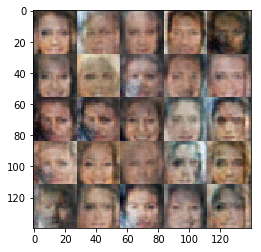

Epoch 5/10... Discriminator Loss: 0.1124... Generator Loss: 3.0329
Epoch 5/10... Discriminator Loss: 0.1366... Generator Loss: 2.7158
Epoch 5/10... Discriminator Loss: 0.1200... Generator Loss: 2.9100
Epoch 5/10... Discriminator Loss: 0.4508... Generator Loss: 1.2215
Epoch 5/10... Discriminator Loss: 0.0800... Generator Loss: 4.6344
Epoch 5/10... Discriminator Loss: 0.1264... Generator Loss: 2.8283
Epoch 5/10... Discriminator Loss: 0.0846... Generator Loss: 3.1836
Epoch 5/10... Discriminator Loss: 0.0217... Generator Loss: 5.4742
Epoch 5/10... Discriminator Loss: 0.1461... Generator Loss: 6.2971
Epoch 5/10... Discriminator Loss: 0.3386... Generator Loss: 12.4648


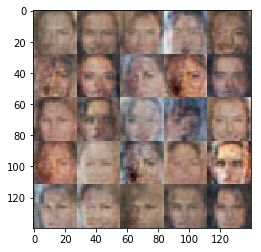

Epoch 5/10... Discriminator Loss: 0.0934... Generator Loss: 3.5387
Epoch 5/10... Discriminator Loss: 0.0668... Generator Loss: 7.5788
Epoch 5/10... Discriminator Loss: 0.0208... Generator Loss: 9.7487
Epoch 5/10... Discriminator Loss: 0.1259... Generator Loss: 6.8868
Epoch 5/10... Discriminator Loss: 0.0195... Generator Loss: 6.0367
Epoch 5/10... Discriminator Loss: 0.0319... Generator Loss: 6.8419
Epoch 5/10... Discriminator Loss: 0.2590... Generator Loss: 2.0591
Epoch 5/10... Discriminator Loss: 0.0322... Generator Loss: 4.7088
Epoch 5/10... Discriminator Loss: 0.2972... Generator Loss: 2.6601
Epoch 5/10... Discriminator Loss: 0.1295... Generator Loss: 3.6901


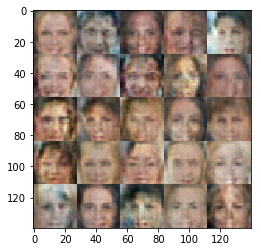

Epoch 5/10... Discriminator Loss: 0.0873... Generator Loss: 4.8363
Epoch 5/10... Discriminator Loss: 0.4407... Generator Loss: 5.2073
Epoch 5/10... Discriminator Loss: 0.4484... Generator Loss: 1.3231
Epoch 5/10... Discriminator Loss: 0.4391... Generator Loss: 1.3051
Epoch 5/10... Discriminator Loss: 0.0688... Generator Loss: 3.7615
Epoch 5/10... Discriminator Loss: 0.0853... Generator Loss: 5.8190
Epoch 5/10... Discriminator Loss: 0.1801... Generator Loss: 5.0146
Epoch 5/10... Discriminator Loss: 0.4005... Generator Loss: 5.5511
Epoch 5/10... Discriminator Loss: 0.0584... Generator Loss: 5.6959
Epoch 5/10... Discriminator Loss: 0.0652... Generator Loss: 5.9678


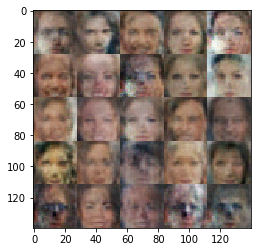

Epoch 5/10... Discriminator Loss: 0.0831... Generator Loss: 4.3978
Epoch 5/10... Discriminator Loss: 0.0447... Generator Loss: 7.6453
Epoch 5/10... Discriminator Loss: 0.0968... Generator Loss: 3.5071
Epoch 5/10... Discriminator Loss: 0.4340... Generator Loss: 1.3060
Epoch 5/10... Discriminator Loss: 0.2109... Generator Loss: 7.3500
Epoch 5/10... Discriminator Loss: 0.0433... Generator Loss: 4.9288
Epoch 5/10... Discriminator Loss: 0.0544... Generator Loss: 6.0671
Epoch 5/10... Discriminator Loss: 0.0222... Generator Loss: 6.0639
Epoch 5/10... Discriminator Loss: 0.2308... Generator Loss: 8.5577
Epoch 5/10... Discriminator Loss: 0.0113... Generator Loss: 11.6005


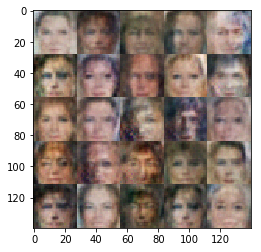

Epoch 5/10... Discriminator Loss: 0.1372... Generator Loss: 11.0406
Epoch 5/10... Discriminator Loss: 0.0608... Generator Loss: 11.6480
Epoch 5/10... Discriminator Loss: 0.0731... Generator Loss: 7.1609
Epoch 5/10... Discriminator Loss: 0.0401... Generator Loss: 5.2607
Epoch 5/10... Discriminator Loss: 0.1397... Generator Loss: 3.7630
Epoch 5/10... Discriminator Loss: 0.0428... Generator Loss: 4.9883
Epoch 5/10... Discriminator Loss: 0.0357... Generator Loss: 5.1933
Epoch 5/10... Discriminator Loss: 0.6230... Generator Loss: 5.7086
Epoch 5/10... Discriminator Loss: 0.0918... Generator Loss: 9.7404
Epoch 5/10... Discriminator Loss: 0.0299... Generator Loss: 7.9364


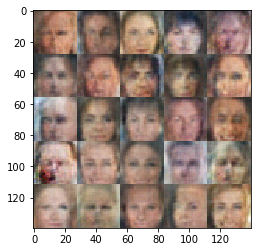

Epoch 5/10... Discriminator Loss: 0.0446... Generator Loss: 5.3492
Epoch 5/10... Discriminator Loss: 0.4197... Generator Loss: 5.1943
Epoch 5/10... Discriminator Loss: 0.0399... Generator Loss: 5.0491
Epoch 5/10... Discriminator Loss: 0.0992... Generator Loss: 6.5776
Epoch 5/10... Discriminator Loss: 0.0337... Generator Loss: 9.5311
Epoch 5/10... Discriminator Loss: 0.1103... Generator Loss: 4.2360
Epoch 5/10... Discriminator Loss: 0.0318... Generator Loss: 10.7437
Epoch 5/10... Discriminator Loss: 0.2225... Generator Loss: 3.4021
Epoch 5/10... Discriminator Loss: 0.0211... Generator Loss: 10.1046
Epoch 5/10... Discriminator Loss: 0.1082... Generator Loss: 3.3173


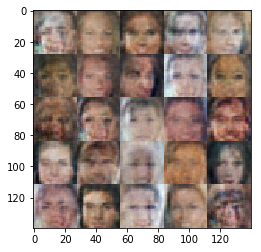

Epoch 5/10... Discriminator Loss: 0.1417... Generator Loss: 3.8347
Epoch 5/10... Discriminator Loss: 0.3850... Generator Loss: 7.2122
Epoch 5/10... Discriminator Loss: 0.3779... Generator Loss: 5.5534
Epoch 5/10... Discriminator Loss: 0.2848... Generator Loss: 3.4989
Epoch 5/10... Discriminator Loss: 0.1383... Generator Loss: 4.5678
Epoch 6/10... Discriminator Loss: 0.4424... Generator Loss: 1.3455
Epoch 6/10... Discriminator Loss: 0.1860... Generator Loss: 4.6490
Epoch 6/10... Discriminator Loss: 0.1010... Generator Loss: 5.1844
Epoch 6/10... Discriminator Loss: 0.0941... Generator Loss: 4.4598
Epoch 6/10... Discriminator Loss: 0.0511... Generator Loss: 7.1021


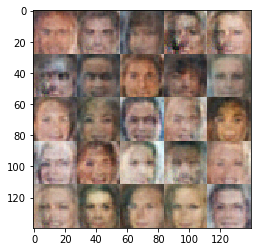

Epoch 6/10... Discriminator Loss: 0.3212... Generator Loss: 5.2027
Epoch 6/10... Discriminator Loss: 0.0864... Generator Loss: 3.7924
Epoch 6/10... Discriminator Loss: 0.2293... Generator Loss: 2.1267
Epoch 6/10... Discriminator Loss: 0.0612... Generator Loss: 5.9845
Epoch 6/10... Discriminator Loss: 0.1752... Generator Loss: 7.9638
Epoch 6/10... Discriminator Loss: 0.0771... Generator Loss: 4.1415
Epoch 6/10... Discriminator Loss: 0.1620... Generator Loss: 5.3926
Epoch 6/10... Discriminator Loss: 0.1917... Generator Loss: 3.7333
Epoch 6/10... Discriminator Loss: 0.0746... Generator Loss: 5.8556
Epoch 6/10... Discriminator Loss: 0.0904... Generator Loss: 3.4975


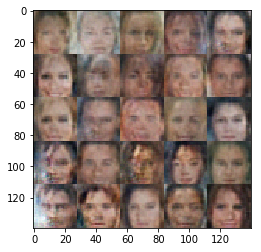

Epoch 6/10... Discriminator Loss: 0.1483... Generator Loss: 3.3389
Epoch 6/10... Discriminator Loss: 0.5061... Generator Loss: 1.4269
Epoch 6/10... Discriminator Loss: 0.1373... Generator Loss: 6.3019
Epoch 6/10... Discriminator Loss: 0.4515... Generator Loss: 1.2569
Epoch 6/10... Discriminator Loss: 0.3032... Generator Loss: 1.6670
Epoch 6/10... Discriminator Loss: 0.0606... Generator Loss: 5.0581
Epoch 6/10... Discriminator Loss: 0.2130... Generator Loss: 9.4816
Epoch 6/10... Discriminator Loss: 0.0220... Generator Loss: 8.7069
Epoch 6/10... Discriminator Loss: 0.1202... Generator Loss: 6.1410
Epoch 6/10... Discriminator Loss: 0.1671... Generator Loss: 10.5589


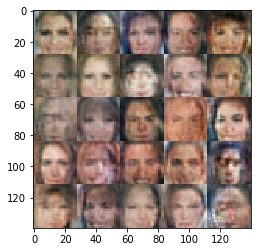

Epoch 6/10... Discriminator Loss: 0.0316... Generator Loss: 5.5368
Epoch 6/10... Discriminator Loss: 0.1424... Generator Loss: 2.6285
Epoch 6/10... Discriminator Loss: 0.0923... Generator Loss: 4.6185
Epoch 6/10... Discriminator Loss: 0.1341... Generator Loss: 10.6087
Epoch 6/10... Discriminator Loss: 0.3255... Generator Loss: 1.6130
Epoch 6/10... Discriminator Loss: 0.0690... Generator Loss: 4.2546
Epoch 6/10... Discriminator Loss: 0.2722... Generator Loss: 1.9737
Epoch 6/10... Discriminator Loss: 0.1150... Generator Loss: 3.2198
Epoch 6/10... Discriminator Loss: 0.1366... Generator Loss: 3.1674
Epoch 6/10... Discriminator Loss: 0.3760... Generator Loss: 1.4088


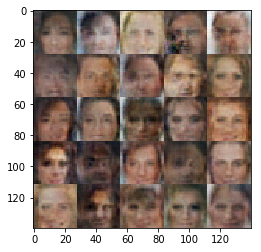

Epoch 6/10... Discriminator Loss: 0.0972... Generator Loss: 4.1375
Epoch 6/10... Discriminator Loss: 0.1252... Generator Loss: 11.0148
Epoch 6/10... Discriminator Loss: 0.1554... Generator Loss: 8.1851
Epoch 6/10... Discriminator Loss: 0.0546... Generator Loss: 6.2646
Epoch 6/10... Discriminator Loss: 0.0176... Generator Loss: 8.7539
Epoch 6/10... Discriminator Loss: 0.4105... Generator Loss: 7.2708
Epoch 6/10... Discriminator Loss: 0.0158... Generator Loss: 8.8898
Epoch 6/10... Discriminator Loss: 0.0748... Generator Loss: 9.2742
Epoch 6/10... Discriminator Loss: 0.0938... Generator Loss: 3.5665
Epoch 6/10... Discriminator Loss: 0.2385... Generator Loss: 2.0713


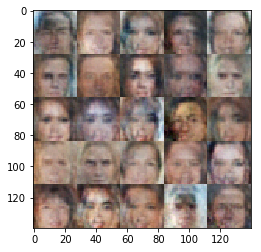

Epoch 6/10... Discriminator Loss: 0.0360... Generator Loss: 11.8699
Epoch 6/10... Discriminator Loss: 0.0605... Generator Loss: 4.6405
Epoch 6/10... Discriminator Loss: 0.1890... Generator Loss: 2.5132
Epoch 6/10... Discriminator Loss: 0.1870... Generator Loss: 2.5988
Epoch 6/10... Discriminator Loss: 0.1328... Generator Loss: 6.2900
Epoch 6/10... Discriminator Loss: 0.0655... Generator Loss: 10.7598
Epoch 6/10... Discriminator Loss: 0.0645... Generator Loss: 4.2669
Epoch 6/10... Discriminator Loss: 0.0439... Generator Loss: 6.1590
Epoch 6/10... Discriminator Loss: 0.0600... Generator Loss: 5.2038
Epoch 6/10... Discriminator Loss: 0.0957... Generator Loss: 3.5473


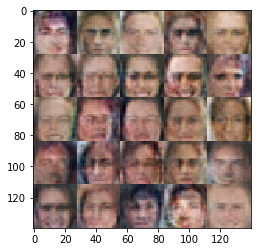

Epoch 6/10... Discriminator Loss: 0.5594... Generator Loss: 1.1129
Epoch 6/10... Discriminator Loss: 0.0978... Generator Loss: 10.1559
Epoch 6/10... Discriminator Loss: 0.1302... Generator Loss: 2.9445
Epoch 6/10... Discriminator Loss: 0.0873... Generator Loss: 3.4747
Epoch 6/10... Discriminator Loss: 0.0957... Generator Loss: 3.4290
Epoch 6/10... Discriminator Loss: 0.2033... Generator Loss: 2.2088
Epoch 6/10... Discriminator Loss: 0.1248... Generator Loss: 3.0020
Epoch 6/10... Discriminator Loss: 0.1205... Generator Loss: 3.7968
Epoch 6/10... Discriminator Loss: 0.0329... Generator Loss: 6.3833
Epoch 6/10... Discriminator Loss: 0.2368... Generator Loss: 2.0848


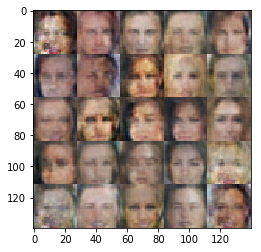

Epoch 6/10... Discriminator Loss: 0.0384... Generator Loss: 5.0236
Epoch 6/10... Discriminator Loss: 0.0719... Generator Loss: 5.1456
Epoch 6/10... Discriminator Loss: 0.0304... Generator Loss: 6.5094
Epoch 6/10... Discriminator Loss: 0.0353... Generator Loss: 5.8896
Epoch 6/10... Discriminator Loss: 0.0943... Generator Loss: 3.6284
Epoch 6/10... Discriminator Loss: 0.0592... Generator Loss: 5.2383
Epoch 6/10... Discriminator Loss: 0.6569... Generator Loss: 7.1390
Epoch 6/10... Discriminator Loss: 0.1751... Generator Loss: 4.7322
Epoch 6/10... Discriminator Loss: 0.0661... Generator Loss: 4.9739
Epoch 6/10... Discriminator Loss: 0.2531... Generator Loss: 11.2663


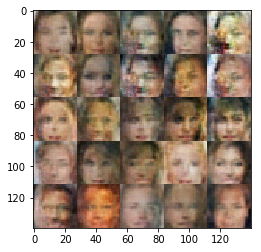

Epoch 6/10... Discriminator Loss: 0.0532... Generator Loss: 9.1695
Epoch 6/10... Discriminator Loss: 0.0595... Generator Loss: 7.2300
Epoch 6/10... Discriminator Loss: 0.0314... Generator Loss: 6.4247
Epoch 6/10... Discriminator Loss: 0.3106... Generator Loss: 10.7345
Epoch 7/10... Discriminator Loss: 0.5637... Generator Loss: 1.1408
Epoch 7/10... Discriminator Loss: 0.0168... Generator Loss: 8.3567
Epoch 7/10... Discriminator Loss: 0.0503... Generator Loss: 5.4786
Epoch 7/10... Discriminator Loss: 0.3243... Generator Loss: 15.0896
Epoch 7/10... Discriminator Loss: 0.1046... Generator Loss: 6.0387
Epoch 7/10... Discriminator Loss: 0.0527... Generator Loss: 4.3097


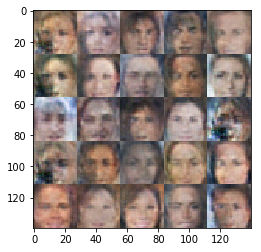

Epoch 7/10... Discriminator Loss: 0.5752... Generator Loss: 0.9919
Epoch 7/10... Discriminator Loss: 0.0249... Generator Loss: 7.3821
Epoch 7/10... Discriminator Loss: 0.0427... Generator Loss: 6.0542
Epoch 7/10... Discriminator Loss: 0.7432... Generator Loss: 0.8232
Epoch 7/10... Discriminator Loss: 0.6552... Generator Loss: 1.0544
Epoch 7/10... Discriminator Loss: 0.6444... Generator Loss: 0.9552
Epoch 7/10... Discriminator Loss: 0.0226... Generator Loss: 8.0745
Epoch 7/10... Discriminator Loss: 0.5675... Generator Loss: 1.0590
Epoch 7/10... Discriminator Loss: 0.9723... Generator Loss: 0.6333
Epoch 7/10... Discriminator Loss: 0.0157... Generator Loss: 11.4894


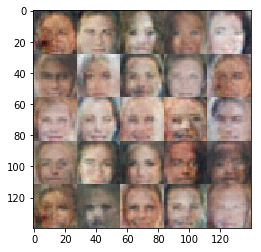

Epoch 7/10... Discriminator Loss: 0.1172... Generator Loss: 8.7979
Epoch 7/10... Discriminator Loss: 0.1118... Generator Loss: 9.8033
Epoch 7/10... Discriminator Loss: 0.0098... Generator Loss: 7.6347
Epoch 7/10... Discriminator Loss: 0.0235... Generator Loss: 8.6613
Epoch 7/10... Discriminator Loss: 0.6724... Generator Loss: 0.9343
Epoch 7/10... Discriminator Loss: 1.5875... Generator Loss: 0.4421
Epoch 7/10... Discriminator Loss: 0.3875... Generator Loss: 1.8098
Epoch 7/10... Discriminator Loss: 1.5430... Generator Loss: 0.3621
Epoch 7/10... Discriminator Loss: 0.1918... Generator Loss: 3.9565
Epoch 7/10... Discriminator Loss: 0.5850... Generator Loss: 1.0832


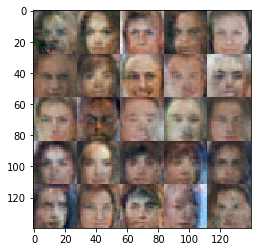

Epoch 7/10... Discriminator Loss: 0.1932... Generator Loss: 3.7543
Epoch 7/10... Discriminator Loss: 0.0746... Generator Loss: 7.4355
Epoch 7/10... Discriminator Loss: 0.3893... Generator Loss: 1.3794
Epoch 7/10... Discriminator Loss: 0.3595... Generator Loss: 1.4865
Epoch 7/10... Discriminator Loss: 0.2037... Generator Loss: 2.5034
Epoch 7/10... Discriminator Loss: 0.5486... Generator Loss: 1.0838
Epoch 7/10... Discriminator Loss: 0.4078... Generator Loss: 1.4182
Epoch 7/10... Discriminator Loss: 0.0151... Generator Loss: 9.4047
Epoch 7/10... Discriminator Loss: 0.8250... Generator Loss: 1.0706
Epoch 7/10... Discriminator Loss: 0.3439... Generator Loss: 1.9870


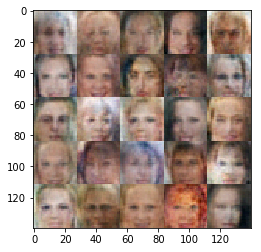

Epoch 7/10... Discriminator Loss: 0.2157... Generator Loss: 5.0215
Epoch 7/10... Discriminator Loss: 0.1530... Generator Loss: 6.9471
Epoch 7/10... Discriminator Loss: 0.0931... Generator Loss: 4.3712
Epoch 7/10... Discriminator Loss: 0.0809... Generator Loss: 4.3274
Epoch 7/10... Discriminator Loss: 1.1198... Generator Loss: 0.5494
Epoch 7/10... Discriminator Loss: 0.0353... Generator Loss: 5.9406
Epoch 7/10... Discriminator Loss: 0.0282... Generator Loss: 5.6503
Epoch 7/10... Discriminator Loss: 0.1821... Generator Loss: 2.3886
Epoch 7/10... Discriminator Loss: 0.1536... Generator Loss: 7.5303
Epoch 7/10... Discriminator Loss: 0.0565... Generator Loss: 4.4943


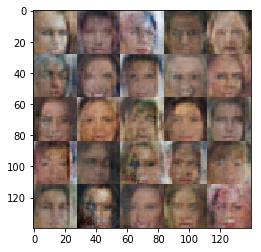

Epoch 7/10... Discriminator Loss: 0.1980... Generator Loss: 7.8642
Epoch 7/10... Discriminator Loss: 0.5662... Generator Loss: 1.1494
Epoch 7/10... Discriminator Loss: 0.2450... Generator Loss: 1.8937
Epoch 7/10... Discriminator Loss: 0.0528... Generator Loss: 8.5822
Epoch 7/10... Discriminator Loss: 0.0350... Generator Loss: 8.6668
Epoch 7/10... Discriminator Loss: 0.0286... Generator Loss: 6.2517
Epoch 7/10... Discriminator Loss: 0.1909... Generator Loss: 2.9355
Epoch 7/10... Discriminator Loss: 0.3422... Generator Loss: 1.6844
Epoch 7/10... Discriminator Loss: 0.1426... Generator Loss: 4.5448
Epoch 7/10... Discriminator Loss: 0.4389... Generator Loss: 1.2801


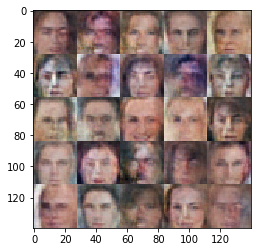

Epoch 7/10... Discriminator Loss: 0.1476... Generator Loss: 7.3944
Epoch 7/10... Discriminator Loss: 0.0712... Generator Loss: 4.4034
Epoch 7/10... Discriminator Loss: 0.1920... Generator Loss: 2.2356
Epoch 7/10... Discriminator Loss: 0.1085... Generator Loss: 4.7025
Epoch 7/10... Discriminator Loss: 0.0613... Generator Loss: 3.9537
Epoch 7/10... Discriminator Loss: 0.0278... Generator Loss: 10.8058
Epoch 7/10... Discriminator Loss: 0.1129... Generator Loss: 2.7860
Epoch 7/10... Discriminator Loss: 0.1367... Generator Loss: 2.8547
Epoch 7/10... Discriminator Loss: 0.0287... Generator Loss: 9.0998
Epoch 7/10... Discriminator Loss: 0.1835... Generator Loss: 4.8928


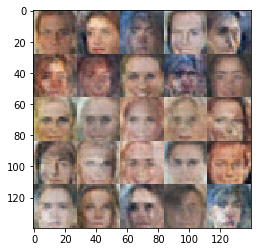

Epoch 7/10... Discriminator Loss: 0.1942... Generator Loss: 4.4781
Epoch 7/10... Discriminator Loss: 0.0713... Generator Loss: 7.7170
Epoch 7/10... Discriminator Loss: 0.1828... Generator Loss: 3.7903
Epoch 7/10... Discriminator Loss: 0.0190... Generator Loss: 9.3019
Epoch 7/10... Discriminator Loss: 0.0659... Generator Loss: 5.5752
Epoch 7/10... Discriminator Loss: 0.0665... Generator Loss: 6.4871
Epoch 7/10... Discriminator Loss: 0.0404... Generator Loss: 5.4600
Epoch 7/10... Discriminator Loss: 0.0610... Generator Loss: 4.4832
Epoch 7/10... Discriminator Loss: 0.2435... Generator Loss: 3.2199
Epoch 7/10... Discriminator Loss: 0.2960... Generator Loss: 1.8410


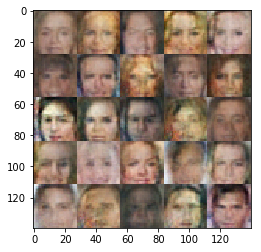

Epoch 7/10... Discriminator Loss: 0.1498... Generator Loss: 7.0840
Epoch 7/10... Discriminator Loss: 0.2982... Generator Loss: 6.3822
Epoch 7/10... Discriminator Loss: 7.9292... Generator Loss: 9.6278
Epoch 8/10... Discriminator Loss: 1.4374... Generator Loss: 1.0354
Epoch 8/10... Discriminator Loss: 1.1478... Generator Loss: 1.0980
Epoch 8/10... Discriminator Loss: 0.8805... Generator Loss: 1.2840
Epoch 8/10... Discriminator Loss: 0.3341... Generator Loss: 2.3314
Epoch 8/10... Discriminator Loss: 0.6006... Generator Loss: 1.2008
Epoch 8/10... Discriminator Loss: 0.3113... Generator Loss: 1.7011
Epoch 8/10... Discriminator Loss: 0.2323... Generator Loss: 5.5999


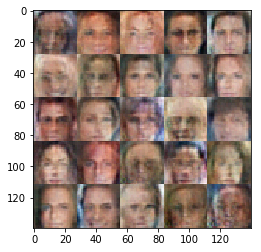

Epoch 8/10... Discriminator Loss: 0.0926... Generator Loss: 4.6211
Epoch 8/10... Discriminator Loss: 0.2711... Generator Loss: 1.9339
Epoch 8/10... Discriminator Loss: 0.3945... Generator Loss: 1.4707
Epoch 8/10... Discriminator Loss: 0.1692... Generator Loss: 2.8085
Epoch 8/10... Discriminator Loss: 0.0925... Generator Loss: 7.6481
Epoch 8/10... Discriminator Loss: 0.2307... Generator Loss: 7.9111
Epoch 8/10... Discriminator Loss: 0.0965... Generator Loss: 4.0259
Epoch 8/10... Discriminator Loss: 0.2956... Generator Loss: 3.7487
Epoch 8/10... Discriminator Loss: 0.4245... Generator Loss: 1.3430
Epoch 8/10... Discriminator Loss: 0.0693... Generator Loss: 6.4348


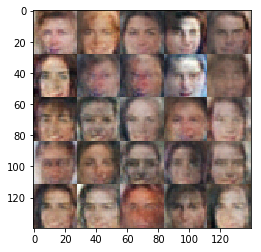

Epoch 8/10... Discriminator Loss: 0.0547... Generator Loss: 4.5284
Epoch 8/10... Discriminator Loss: 0.0700... Generator Loss: 8.7101
Epoch 8/10... Discriminator Loss: 0.7153... Generator Loss: 0.8123
Epoch 8/10... Discriminator Loss: 0.0332... Generator Loss: 6.4364
Epoch 8/10... Discriminator Loss: 0.1675... Generator Loss: 3.5366
Epoch 8/10... Discriminator Loss: 0.0486... Generator Loss: 6.8351
Epoch 8/10... Discriminator Loss: 0.1215... Generator Loss: 5.8675
Epoch 8/10... Discriminator Loss: 0.0503... Generator Loss: 4.1621
Epoch 8/10... Discriminator Loss: 0.0389... Generator Loss: 6.5030
Epoch 8/10... Discriminator Loss: 0.0485... Generator Loss: 6.2109


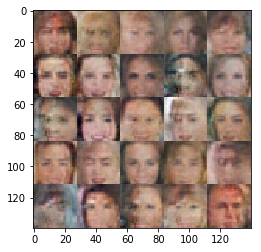

Epoch 8/10... Discriminator Loss: 0.0702... Generator Loss: 4.7827
Epoch 8/10... Discriminator Loss: 0.0473... Generator Loss: 6.3045
Epoch 8/10... Discriminator Loss: 0.0679... Generator Loss: 6.0259
Epoch 8/10... Discriminator Loss: 0.0163... Generator Loss: 7.1844
Epoch 8/10... Discriminator Loss: 0.0641... Generator Loss: 5.1071
Epoch 8/10... Discriminator Loss: 0.0311... Generator Loss: 9.1344
Epoch 8/10... Discriminator Loss: 0.1230... Generator Loss: 9.1676
Epoch 8/10... Discriminator Loss: 0.0634... Generator Loss: 3.5447
Epoch 8/10... Discriminator Loss: 0.1270... Generator Loss: 6.7978
Epoch 8/10... Discriminator Loss: 0.1523... Generator Loss: 3.1353


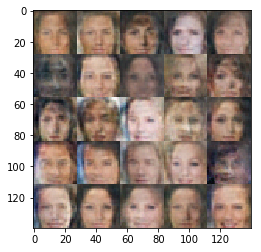

Epoch 8/10... Discriminator Loss: 0.0785... Generator Loss: 4.2783
Epoch 8/10... Discriminator Loss: 0.0473... Generator Loss: 8.2619
Epoch 8/10... Discriminator Loss: 0.0503... Generator Loss: 5.2619
Epoch 8/10... Discriminator Loss: 0.0689... Generator Loss: 6.4897
Epoch 8/10... Discriminator Loss: 0.5816... Generator Loss: 5.1750
Epoch 8/10... Discriminator Loss: 0.1259... Generator Loss: 13.0729
Epoch 8/10... Discriminator Loss: 0.4368... Generator Loss: 1.3398
Epoch 8/10... Discriminator Loss: 0.0884... Generator Loss: 4.8353
Epoch 8/10... Discriminator Loss: 0.0445... Generator Loss: 9.6987
Epoch 8/10... Discriminator Loss: 0.1637... Generator Loss: 2.3925


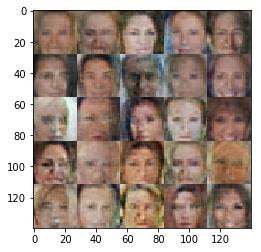

Epoch 8/10... Discriminator Loss: 0.3196... Generator Loss: 8.4355
Epoch 8/10... Discriminator Loss: 0.0340... Generator Loss: 6.1377
Epoch 8/10... Discriminator Loss: 0.1497... Generator Loss: 2.5363
Epoch 8/10... Discriminator Loss: 0.0641... Generator Loss: 7.3632
Epoch 8/10... Discriminator Loss: 0.0302... Generator Loss: 6.1205
Epoch 8/10... Discriminator Loss: 1.0243... Generator Loss: 0.6045
Epoch 8/10... Discriminator Loss: 0.0891... Generator Loss: 5.5898
Epoch 8/10... Discriminator Loss: 0.2081... Generator Loss: 2.5418
Epoch 8/10... Discriminator Loss: 0.2129... Generator Loss: 3.4342
Epoch 8/10... Discriminator Loss: 0.1485... Generator Loss: 2.6920


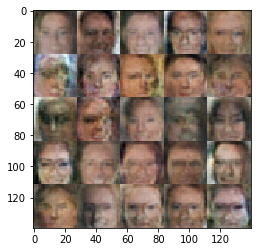

Epoch 8/10... Discriminator Loss: 0.1992... Generator Loss: 2.2048
Epoch 8/10... Discriminator Loss: 0.2741... Generator Loss: 1.8379
Epoch 8/10... Discriminator Loss: 0.0919... Generator Loss: 4.1805
Epoch 8/10... Discriminator Loss: 0.0980... Generator Loss: 3.5703
Epoch 8/10... Discriminator Loss: 0.1173... Generator Loss: 5.7185
Epoch 8/10... Discriminator Loss: 0.0965... Generator Loss: 3.2318
Epoch 8/10... Discriminator Loss: 0.1410... Generator Loss: 6.0204
Epoch 8/10... Discriminator Loss: 0.0562... Generator Loss: 6.7342
Epoch 8/10... Discriminator Loss: 0.2624... Generator Loss: 9.4402
Epoch 8/10... Discriminator Loss: 0.1501... Generator Loss: 2.5941


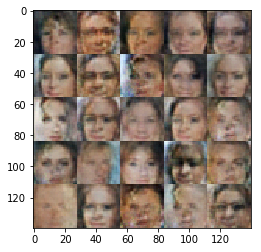

Epoch 8/10... Discriminator Loss: 0.7572... Generator Loss: 0.8414
Epoch 8/10... Discriminator Loss: 0.0486... Generator Loss: 5.6491
Epoch 8/10... Discriminator Loss: 0.2027... Generator Loss: 7.9851
Epoch 8/10... Discriminator Loss: 0.0421... Generator Loss: 7.0950
Epoch 8/10... Discriminator Loss: 0.0894... Generator Loss: 9.6674
Epoch 8/10... Discriminator Loss: 0.0836... Generator Loss: 6.4997
Epoch 8/10... Discriminator Loss: 0.0351... Generator Loss: 8.6537
Epoch 8/10... Discriminator Loss: 0.8958... Generator Loss: 0.6608
Epoch 8/10... Discriminator Loss: 0.0680... Generator Loss: 5.2392
Epoch 8/10... Discriminator Loss: 0.4284... Generator Loss: 1.6282


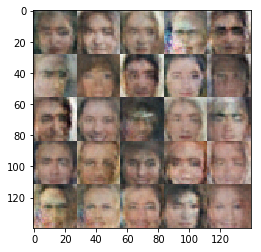

Epoch 8/10... Discriminator Loss: 0.0185... Generator Loss: 6.8797
Epoch 8/10... Discriminator Loss: 1.0004... Generator Loss: 0.6651
Epoch 9/10... Discriminator Loss: 0.0487... Generator Loss: 6.2531
Epoch 9/10... Discriminator Loss: 0.2778... Generator Loss: 2.6379
Epoch 9/10... Discriminator Loss: 0.0292... Generator Loss: 5.4969
Epoch 9/10... Discriminator Loss: 0.5190... Generator Loss: 1.2288
Epoch 9/10... Discriminator Loss: 0.0285... Generator Loss: 9.4278
Epoch 9/10... Discriminator Loss: 0.0242... Generator Loss: 8.0376
Epoch 9/10... Discriminator Loss: 1.2854... Generator Loss: 4.0778
Epoch 9/10... Discriminator Loss: 0.1955... Generator Loss: 2.7785


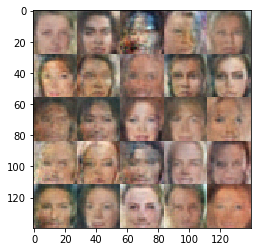

Epoch 9/10... Discriminator Loss: 0.0821... Generator Loss: 4.4595
Epoch 9/10... Discriminator Loss: 0.2389... Generator Loss: 3.9210
Epoch 9/10... Discriminator Loss: 0.0522... Generator Loss: 8.2205
Epoch 9/10... Discriminator Loss: 0.0623... Generator Loss: 6.9494
Epoch 9/10... Discriminator Loss: 0.0425... Generator Loss: 7.1805
Epoch 9/10... Discriminator Loss: 0.1081... Generator Loss: 3.3044
Epoch 9/10... Discriminator Loss: 0.1437... Generator Loss: 7.5835
Epoch 9/10... Discriminator Loss: 0.0261... Generator Loss: 8.0121
Epoch 9/10... Discriminator Loss: 0.0115... Generator Loss: 10.0857
Epoch 9/10... Discriminator Loss: 0.0782... Generator Loss: 3.7775


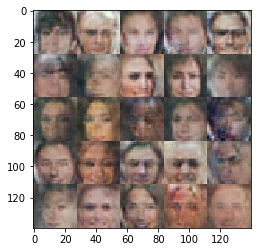

Epoch 9/10... Discriminator Loss: 0.1599... Generator Loss: 2.4201
Epoch 9/10... Discriminator Loss: 0.0761... Generator Loss: 3.6120
Epoch 9/10... Discriminator Loss: 0.1498... Generator Loss: 3.1907
Epoch 9/10... Discriminator Loss: 0.0749... Generator Loss: 5.0475
Epoch 9/10... Discriminator Loss: 0.0195... Generator Loss: 6.7847
Epoch 9/10... Discriminator Loss: 0.0531... Generator Loss: 9.1359
Epoch 9/10... Discriminator Loss: 0.0818... Generator Loss: 3.9800
Epoch 9/10... Discriminator Loss: 0.0792... Generator Loss: 5.0084
Epoch 9/10... Discriminator Loss: 0.0092... Generator Loss: 7.5316
Epoch 9/10... Discriminator Loss: 0.0078... Generator Loss: 8.2739


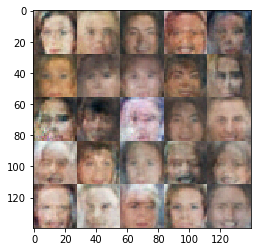

Epoch 9/10... Discriminator Loss: 0.0790... Generator Loss: 4.2602
Epoch 9/10... Discriminator Loss: 0.0298... Generator Loss: 7.5433
Epoch 9/10... Discriminator Loss: 0.0185... Generator Loss: 6.9524
Epoch 9/10... Discriminator Loss: 0.0780... Generator Loss: 4.0270
Epoch 9/10... Discriminator Loss: 0.7152... Generator Loss: 8.4524
Epoch 9/10... Discriminator Loss: 0.2545... Generator Loss: 4.7987
Epoch 9/10... Discriminator Loss: 0.0363... Generator Loss: 7.6971
Epoch 9/10... Discriminator Loss: 0.1465... Generator Loss: 2.7010
Epoch 9/10... Discriminator Loss: 0.0205... Generator Loss: 8.5266
Epoch 9/10... Discriminator Loss: 0.0653... Generator Loss: 8.6813


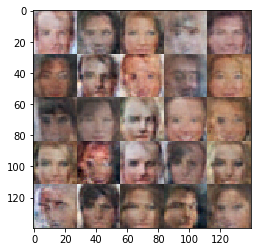

Epoch 9/10... Discriminator Loss: 0.1234... Generator Loss: 4.7758
Epoch 9/10... Discriminator Loss: 0.0143... Generator Loss: 10.0616
Epoch 9/10... Discriminator Loss: 0.0723... Generator Loss: 11.4700
Epoch 9/10... Discriminator Loss: 0.0386... Generator Loss: 5.7560
Epoch 9/10... Discriminator Loss: 0.1719... Generator Loss: 8.5095
Epoch 9/10... Discriminator Loss: 0.1828... Generator Loss: 2.3377
Epoch 9/10... Discriminator Loss: 0.0852... Generator Loss: 3.5880
Epoch 9/10... Discriminator Loss: 0.4735... Generator Loss: 1.3850
Epoch 9/10... Discriminator Loss: 0.0512... Generator Loss: 6.0559
Epoch 9/10... Discriminator Loss: 0.2613... Generator Loss: 1.9752


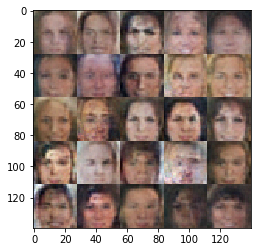

Epoch 9/10... Discriminator Loss: 0.0245... Generator Loss: 9.5428
Epoch 9/10... Discriminator Loss: 0.0307... Generator Loss: 7.8510
Epoch 9/10... Discriminator Loss: 2.4249... Generator Loss: 5.5889
Epoch 9/10... Discriminator Loss: 0.3181... Generator Loss: 2.3276
Epoch 9/10... Discriminator Loss: 0.2229... Generator Loss: 2.8668
Epoch 9/10... Discriminator Loss: 0.1349... Generator Loss: 4.6273
Epoch 9/10... Discriminator Loss: 0.1125... Generator Loss: 4.8939
Epoch 9/10... Discriminator Loss: 0.0543... Generator Loss: 7.5428
Epoch 9/10... Discriminator Loss: 0.1091... Generator Loss: 4.4683
Epoch 9/10... Discriminator Loss: 0.1102... Generator Loss: 5.0284


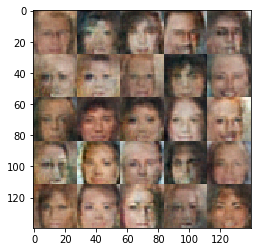

Epoch 9/10... Discriminator Loss: 0.0720... Generator Loss: 5.0708
Epoch 9/10... Discriminator Loss: 0.0755... Generator Loss: 4.6370
Epoch 9/10... Discriminator Loss: 0.0818... Generator Loss: 6.5884
Epoch 9/10... Discriminator Loss: 0.0303... Generator Loss: 7.9078
Epoch 9/10... Discriminator Loss: 0.2149... Generator Loss: 7.0089
Epoch 9/10... Discriminator Loss: 0.0358... Generator Loss: 6.4217
Epoch 9/10... Discriminator Loss: 0.1569... Generator Loss: 3.0059
Epoch 9/10... Discriminator Loss: 0.0756... Generator Loss: 8.0696
Epoch 9/10... Discriminator Loss: 0.1039... Generator Loss: 3.4976
Epoch 9/10... Discriminator Loss: 0.1197... Generator Loss: 3.3219


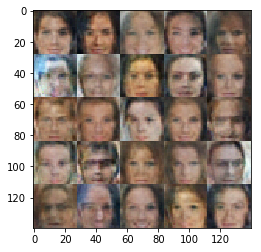

Epoch 9/10... Discriminator Loss: 0.2542... Generator Loss: 2.0026
Epoch 9/10... Discriminator Loss: 0.0640... Generator Loss: 4.1184
Epoch 9/10... Discriminator Loss: 0.1455... Generator Loss: 2.8806
Epoch 9/10... Discriminator Loss: 0.0438... Generator Loss: 6.9504
Epoch 9/10... Discriminator Loss: 0.0435... Generator Loss: 5.3160
Epoch 9/10... Discriminator Loss: 0.0713... Generator Loss: 4.0054
Epoch 9/10... Discriminator Loss: 0.0544... Generator Loss: 5.7052
Epoch 9/10... Discriminator Loss: 0.0502... Generator Loss: 4.3968
Epoch 9/10... Discriminator Loss: 0.0413... Generator Loss: 7.7764
Epoch 9/10... Discriminator Loss: 0.5562... Generator Loss: 1.4526


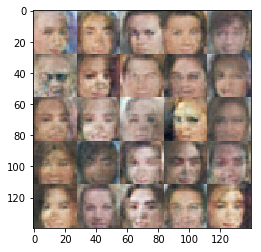

Epoch 9/10... Discriminator Loss: 0.0626... Generator Loss: 5.1970
Epoch 10/10... Discriminator Loss: 0.0564... Generator Loss: 4.0128
Epoch 10/10... Discriminator Loss: 0.0624... Generator Loss: 6.0905
Epoch 10/10... Discriminator Loss: 0.0767... Generator Loss: 3.8396
Epoch 10/10... Discriminator Loss: 1.0871... Generator Loss: 0.5553
Epoch 10/10... Discriminator Loss: 0.2768... Generator Loss: 2.2319
Epoch 10/10... Discriminator Loss: 0.0682... Generator Loss: 4.6111
Epoch 10/10... Discriminator Loss: 0.0634... Generator Loss: 5.3130
Epoch 10/10... Discriminator Loss: 1.0835... Generator Loss: 0.6556
Epoch 10/10... Discriminator Loss: 0.1458... Generator Loss: 5.0748


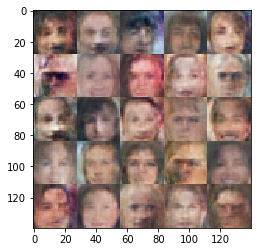

Epoch 10/10... Discriminator Loss: 0.2304... Generator Loss: 6.2001
Epoch 10/10... Discriminator Loss: 0.0400... Generator Loss: 5.1813
Epoch 10/10... Discriminator Loss: 0.0710... Generator Loss: 5.7849
Epoch 10/10... Discriminator Loss: 0.0850... Generator Loss: 5.3449
Epoch 10/10... Discriminator Loss: 0.0784... Generator Loss: 6.1325
Epoch 10/10... Discriminator Loss: 0.0487... Generator Loss: 8.7879
Epoch 10/10... Discriminator Loss: 0.2048... Generator Loss: 2.3879
Epoch 10/10... Discriminator Loss: 0.2197... Generator Loss: 2.6087
Epoch 10/10... Discriminator Loss: 0.0814... Generator Loss: 6.1038
Epoch 10/10... Discriminator Loss: 0.2360... Generator Loss: 12.7001


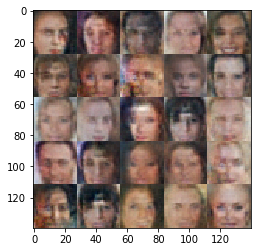

Epoch 10/10... Discriminator Loss: 0.0968... Generator Loss: 7.3319
Epoch 10/10... Discriminator Loss: 0.0910... Generator Loss: 6.2596
Epoch 10/10... Discriminator Loss: 0.6554... Generator Loss: 1.0423
Epoch 10/10... Discriminator Loss: 0.1067... Generator Loss: 7.3715
Epoch 10/10... Discriminator Loss: 0.0512... Generator Loss: 6.0216
Epoch 10/10... Discriminator Loss: 0.0736... Generator Loss: 4.0743
Epoch 10/10... Discriminator Loss: 0.7496... Generator Loss: 0.9176
Epoch 10/10... Discriminator Loss: 0.0763... Generator Loss: 4.4937
Epoch 10/10... Discriminator Loss: 0.2132... Generator Loss: 6.0812
Epoch 10/10... Discriminator Loss: 0.0551... Generator Loss: 9.6010


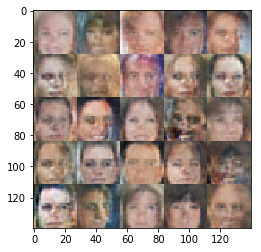

Epoch 10/10... Discriminator Loss: 0.0376... Generator Loss: 6.5535
Epoch 10/10... Discriminator Loss: 0.1560... Generator Loss: 5.6747
Epoch 10/10... Discriminator Loss: 0.0381... Generator Loss: 9.1826
Epoch 10/10... Discriminator Loss: 0.0495... Generator Loss: 9.0557
Epoch 10/10... Discriminator Loss: 0.8581... Generator Loss: 8.6991
Epoch 10/10... Discriminator Loss: 0.2034... Generator Loss: 2.5161
Epoch 10/10... Discriminator Loss: 0.2394... Generator Loss: 1.9689
Epoch 10/10... Discriminator Loss: 0.2673... Generator Loss: 2.2476
Epoch 10/10... Discriminator Loss: 0.1002... Generator Loss: 3.6546
Epoch 10/10... Discriminator Loss: 0.0673... Generator Loss: 4.0034


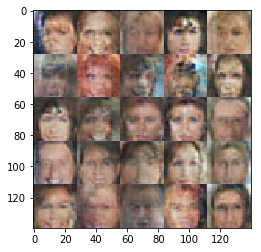

Epoch 10/10... Discriminator Loss: 0.3223... Generator Loss: 1.6946
Epoch 10/10... Discriminator Loss: 0.2510... Generator Loss: 1.9196
Epoch 10/10... Discriminator Loss: 0.0277... Generator Loss: 7.4809
Epoch 10/10... Discriminator Loss: 0.0497... Generator Loss: 6.5654
Epoch 10/10... Discriminator Loss: 0.0285... Generator Loss: 6.1009
Epoch 10/10... Discriminator Loss: 0.0211... Generator Loss: 11.5882
Epoch 10/10... Discriminator Loss: 0.0198... Generator Loss: 6.9314
Epoch 10/10... Discriminator Loss: 0.3125... Generator Loss: 1.7570
Epoch 10/10... Discriminator Loss: 0.2978... Generator Loss: 1.7427
Epoch 10/10... Discriminator Loss: 1.1761... Generator Loss: 0.6998


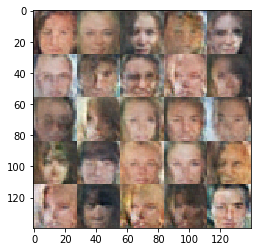

Epoch 10/10... Discriminator Loss: 2.6605... Generator Loss: 0.1811
Epoch 10/10... Discriminator Loss: 0.2583... Generator Loss: 6.4591
Epoch 10/10... Discriminator Loss: 0.1587... Generator Loss: 3.7668
Epoch 10/10... Discriminator Loss: 0.1321... Generator Loss: 5.8018
Epoch 10/10... Discriminator Loss: 0.0607... Generator Loss: 4.0196
Epoch 10/10... Discriminator Loss: 0.1024... Generator Loss: 5.1341
Epoch 10/10... Discriminator Loss: 0.0597... Generator Loss: 5.8013
Epoch 10/10... Discriminator Loss: 0.0700... Generator Loss: 8.2328
Epoch 10/10... Discriminator Loss: 0.1128... Generator Loss: 3.5304
Epoch 10/10... Discriminator Loss: 0.0333... Generator Loss: 6.3060


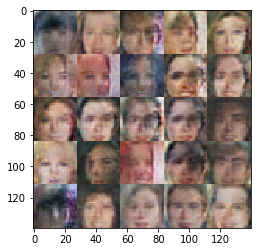

Epoch 10/10... Discriminator Loss: 0.0978... Generator Loss: 3.4301
Epoch 10/10... Discriminator Loss: 0.1435... Generator Loss: 11.5646
Epoch 10/10... Discriminator Loss: 0.1257... Generator Loss: 3.3620
Epoch 10/10... Discriminator Loss: 0.0475... Generator Loss: 8.3078
Epoch 10/10... Discriminator Loss: 0.1952... Generator Loss: 2.4990
Epoch 10/10... Discriminator Loss: 0.0416... Generator Loss: 5.3115
Epoch 10/10... Discriminator Loss: 0.0459... Generator Loss: 5.7102
Epoch 10/10... Discriminator Loss: 0.0579... Generator Loss: 6.3466
Epoch 10/10... Discriminator Loss: 0.8715... Generator Loss: 8.6477
Epoch 10/10... Discriminator Loss: 0.0954... Generator Loss: 3.3153


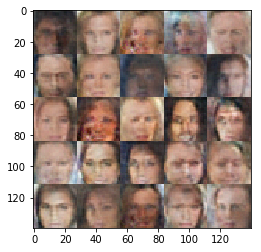

Epoch 10/10... Discriminator Loss: 0.0961... Generator Loss: 9.9297
Epoch 10/10... Discriminator Loss: 0.0426... Generator Loss: 10.9830
Epoch 10/10... Discriminator Loss: 0.1159... Generator Loss: 4.6222
Epoch 10/10... Discriminator Loss: 0.0397... Generator Loss: 8.3348
Epoch 10/10... Discriminator Loss: 0.0629... Generator Loss: 6.7667
Epoch 10/10... Discriminator Loss: 0.0300... Generator Loss: 6.3075
Epoch 10/10... Discriminator Loss: 0.1911... Generator Loss: 2.5697
Epoch 10/10... Discriminator Loss: 0.0314... Generator Loss: 6.9528
Epoch 10/10... Discriminator Loss: 0.0279... Generator Loss: 7.5049
Epoch 10/10... Discriminator Loss: 0.1384... Generator Loss: 3.3962


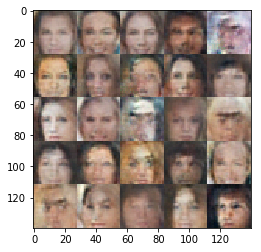

Epoch 10/10... Discriminator Loss: 0.1427... Generator Loss: 4.1857


In [20]:
batch_size = 256
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.